# Table of Contents
* [1) Reading in the data](#1%29-Reading-in-the-data)
* [2) Preprocessing and cleaning the data](#2%29-Preprocessing-and-cleaning-the-data)    
* [3) fit a simple straight line](#3%29-fit-a simple-straight-line)
* [4) fit polynomial function](#4%29-fit-polynomial-function)
* [5) Stepping back to go forward – another look at our data](#5%29-Stepping-back-to-go-forward-–-another-look-at-our-data)
* [6) Training and testing](#6%29-Training-and-testing)
* [7) Answering our initial question](#7%29-Answering-our-initial-question)

On top of the efficient data structures of NumPy, SciPy offers a magnitude of
algorithms working on those arrays. Whatever numerical heavy algorithm you take
from current books on numerical recipes, most likely you will find support for them
in SciPy in one way or the other. Whether it is matrix manipulation, linear algebra,
optimization, clustering, spatial operations, or even fast Fourier transformation, the
toolbox is readily filled. Therefore, it is a good habit to always inspect the scipy
module before you start implementing a numerical algorithm.

# 1) Reading in the data

In [31]:
# %load analyze_webstats.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

%matplotlib inline
import os
from utils import DATA_DIR, CHART_DIR
import scipy as sp
import matplotlib.pyplot as plt

sp.random.seed(3)  # to reproduce the data later on

data = sp.genfromtxt(os.path.join(DATA_DIR, "web_traffic.tsv"), delimiter="\t")
print(data[:10])
print(data.shape)

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]
(743L, 2L)


# 2) Preprocessing and cleaning the data

In [32]:
# all examples will have three classes in this file
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']

x = data[:, 0]
y = data[:, 1]
print("Number of invalid entries:", sp.sum(sp.isnan(y)))

('Number of invalid entries:', 8)


In [33]:
# Remove the invalid entries
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

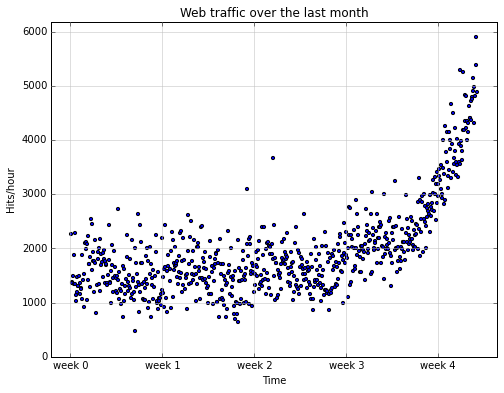

In [34]:
# plot input data
def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):

    plt.figure(num=None, figsize=(8, 6))
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    plt.savefig(fname)

# first look at the data
plot_models(x, y, None, os.path.join(CHART_DIR, "1400_01_01.png"))

# 3) fit a simple straight line

Let's assume for a second that the underlying model is a straight line. Then the
challenge is how to best put that line into the chart so that it results in the smallest
approximation error. SciPy's polyfit() function does exactly that. Given data x and
y and the desired order of the polynomial (a straight line has order 1), it finds the
model function that minimizes the error function defined earlier:

In [35]:
# create and plot models

# Simple straight line
fp1, res1, rank1, sv1, rcond1 = sp.polyfit(x, y, 1, full=True)
print("Model parameters of fp1: %s" % fp1)
print("Error of the model of fp1:", res1)
f1 = sp.poly1d(fp1)

Model parameters of fp1: [   2.59619213  989.02487106]
('Error of the model of fp1:', array([  3.17389767e+08]))


This means the best straight line fit is the following function

$f(x) = 2.59619213 * x + 989.02487106$

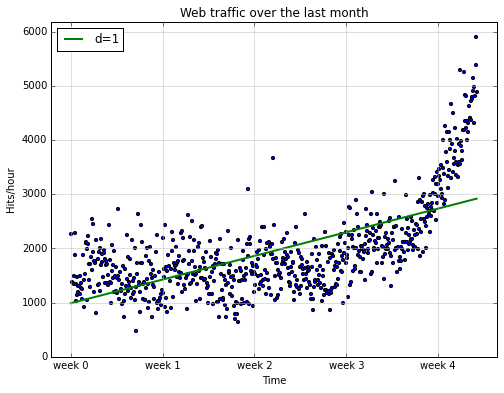

In [36]:
plot_models(x, y, [f1], os.path.join(CHART_DIR, "1400_01_02.png"))

# 4) fit polynomial function

In [37]:
# Let's now fit a more complex model, a polynomial of degree 2
fp2, res2, rank2, sv2, rcond2 = sp.polyfit(x, y, 2, full=True)
print("Model parameters of fp2: %s" % fp2)
print("Error of the model of fp2:", res2)
f2 = sp.poly1d(fp2)

Model parameters of fp2: [  1.05322215e-02  -5.26545650e+00   1.97476082e+03]
('Error of the model of fp2:', array([  1.79983508e+08]))


**$f(x) = 0.0105322215 * x**2 - 5.26545650 * x + 1974.76082$**

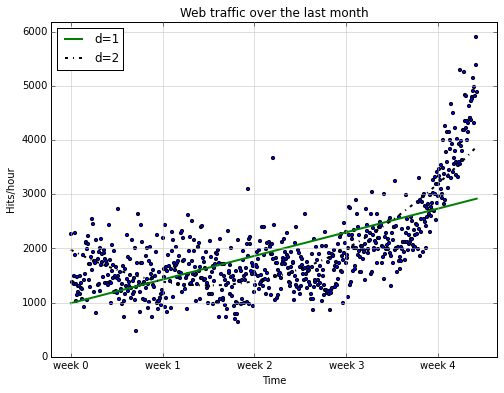

In [38]:
plot_models(x, y, [f1, f2], os.path.join(CHART_DIR, "1400_01_03.png"))

In [39]:
# Let's try it for degrees 3, 10, and 100
f3 = sp.poly1d(sp.polyfit(x, y, 3))

f10 = sp.poly1d(sp.polyfit(x, y, 10))

f100 = sp.poly1d(sp.polyfit(x, y, 100))

C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


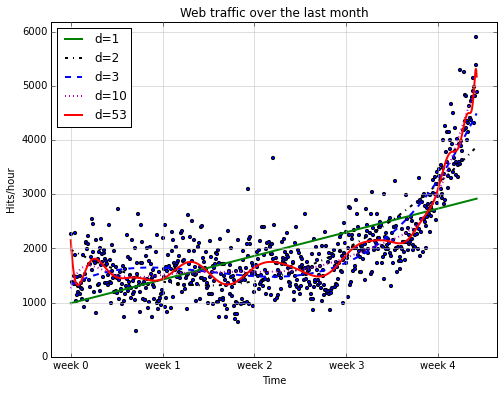

In [40]:
plot_models(
    x, y, [f1, f2, f3, f10, f100], os.path.join(CHART_DIR, "1400_01_04.png"))

# 5) Stepping back to go forward – another look at our data

So, we step back and take another look at the data. It seems that there is an inflection
point between weeks 3 and 4. So let's separate the data and train two lines using
week 3.5 as a separation point:

In [47]:
# fit and plot a model using the knowledge about inflection point
inflection = 3.5 * 7 * 24 # calculate the inflection point in hours
xa = x[:inflection] # data before the inflection point
ya = y[:inflection]
xb = x[inflection:] # data after
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection=%f" % (fa_error + fb_error))

Error inflection=132950348.197616


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


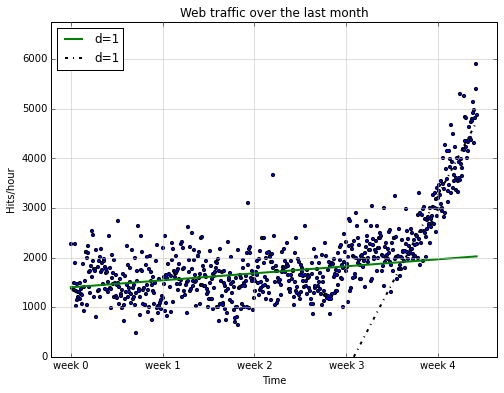

In [48]:
# From the first line, we train with the data up to week 3, and in the second line we
# train with the remaining data.
plot_models(x, y, [fa, fb], os.path.join(CHART_DIR, "1400_01_05.png"))

In [42]:
def error(f, x, y):
    return sp.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, x, y)))

print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

print("Error inflection=%f" % (error(fa, xa, ya) + error(fb, xb, yb)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.878179
Error d=3: 139350144.031725
Error d=10: 121942326.363664
Error d=53: 109452409.941658
Errors for only the time after inflection point
Error d=1: 145045835.134473
Error d=2: 61116348.809620
Error d=3: 33214248.905598
Error d=10: 21611594.265136
Error d=53: 18656112.352438
Error inflection=132950348.197616


The models of degree 10 and 53 don't seem to expect a bright future of our
start-up. They tried so hard to model the given data correctly that they are clearly
useless to extrapolate beyond. This is called overfitting. On the other hand, the
lower degree models seem not to be capable of capturing the data good enough.
This is called underfitting.

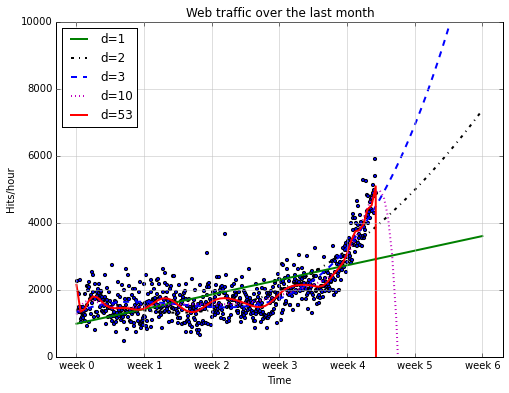

In [43]:
# extrapolating into the future
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    os.path.join(CHART_DIR, "1400_01_06.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

Trained only on data after inflection point
Errors for only the time after inflection point
Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.656480
Error d=53: 18300790.344968


C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


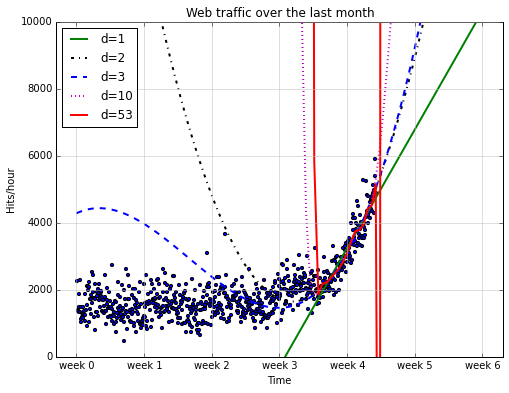

In [44]:
print("Trained only on data after inflection point")
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))

print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    os.path.join(CHART_DIR, "1400_01_07.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

# 6) Training and testing

If we only had some data from the future that we could use to measure our models
against, then we should be able to judge our model choice only on the resulting
approximation error.

In [49]:
# separating training from testing data
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])

In [50]:
fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))
print("fbt2(x)= \n%s"%fbt2)
print("fbt2(x)-100,000= \n%s"%(fbt2-100000))

fbt2(x)= 
        2
0.1031 x - 117.5 x + 3.544e+04
fbt2(x)-100,000= 
        2
0.1031 x - 117.5 x - 6.456e+04


In [51]:
fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))

Test errors for only the time after inflection point
Error d=1: 5884534.411054
Error d=2: 6524875.605450
Error d=3: 6538982.705184
Error d=10: 7323509.948000
Error d=53: 12778972.159027


C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


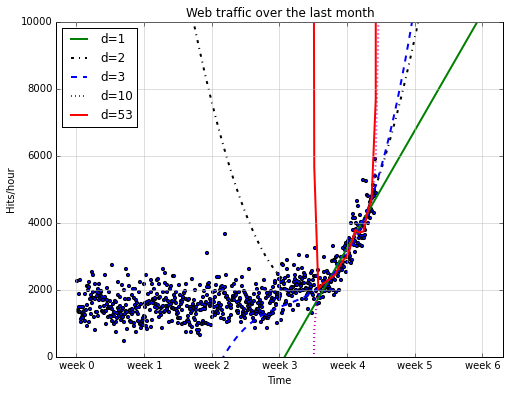

In [52]:
plot_models(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],
    os.path.join(CHART_DIR, "1400_01_08.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

# 7) Answering our initial question

Finally we have arrived at a model which we think represents the underlying process best; it is now a simple task of finding out when our infrastructure will reach 100,000 requests per hour. We have to calculate when our model function reaches the value 100,000.

Having a polynomial of degree 2, we could simply compute the inverse of the function and calculate its value at 100,000. Of course, we would like to have an approach that is applicable to any model function easily.

This can be done by subtracting 100,000 from the polynomial, which results in another polynomial, and finding its root. SciPy's optimize module has the function fsolve that achieves this, when providing an initial starting position with parameter
x0. As every entry in our input data file corresponds to one hour, and we have 743 of them, we set the starting position to some value after that. Let fbt2 be the winning polynomial of degree 2.

In [53]:
from scipy.optimize import fsolve
print(fbt2)
print(fbt2 - 100000)
reached_max = fsolve(fbt2 - 100000, x0=800) / (7 * 24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

        2
0.1031 x - 117.5 x + 3.544e+04
        2
0.1031 x - 117.5 x - 6.456e+04
100,000 hits/hour expected at week 9.195553
